In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import torch

In [2]:
train_df = pd.read_csv("../input/cassandra-udyam-2022/trainData.csv",index_col = "Vendor_Name")
test = pd.read_csv("../input/cassandra-udyam-2022/testData.csv",index_col = "Vendor_Name")
y = train_df['Number_of_Days_until_Payment']
train = train_df.drop('Number_of_Days_until_Payment',axis = 1)


In [3]:
# train.head()

In [4]:
test.head()

,Description,Created,Invoice_Date,Due_Date,Amount,Settled,Outstanding
Vendor_Name,,,,,,,
Aaron Hoffman,Annual Fee,26-11-2015 12:38,30-Nov-15,30-Dec-15,11.98,11.98,0.0
Aaron Murphy,NaN,27-10-2016 10:35,06-Sep-16,06-Oct-16,56.98,56.98,0.0
Aaron Parks,NaN,29-02-2016 00:53,29-Feb-16,14-Mar-16,61.98,61.98,0.0
Aaron Thomas,NaN,27-08-2013 18:46,23-Aug-13,06-Sep-13,674.30,674.30,0.0
Abigail Hernandez,NaN,16-05-2017 16:48,10-May-17,09-Jun-17,302.94,302.94,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8753 entries, David Taylor to James Ayala
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Description   1261 non-null   object 
 1   Created       8753 non-null   object 
 2   Invoice_Date  8753 non-null   object 
 3   Due_Date      8753 non-null   object 
 4   Amount        8753 non-null   float64
 5   Settled       8753 non-null   float64
 6   Outstanding   8753 non-null   float64
dtypes: float64(3), object(4)
memory usage: 547.1+ KB


In [6]:
train.isna().sum()

Description     7492
Created            0
Invoice_Date       0
Due_Date           0
Amount             0
Settled            0
Outstanding        0
dtype: int64

In [7]:
test.isna().sum()

Description     959
Created           0
Invoice_Date      0
Due_Date          0
Amount            0
Settled           0
Outstanding       0
dtype: int64

In [8]:
train1 = train.drop(['Description'],axis = 1)
test1 = test.drop(['Description'],axis = 1)

In [9]:
# a,b = train1['Vendor_Name'].split

In [10]:
def add_date_features(df):
    df['Cyear'] = df['Created'].dt.year
    df['Cmonth'] = df['Created'].dt.month
    df['Cday'] = df['Created'].dt.day
    df['Chour'] = df['Created'].dt.hour
    df['Cmin'] = df['Created'].dt.minute
    
    df['Iyear'] = df['Invoice_Date'].dt.year
    df['Imonth'] = df['Invoice_Date'].dt.month
    df['Iday'] = df['Invoice_Date'].dt.day
    
    df['Dyear'] = df['Due_Date'].dt.year
    df['Dmonth'] = df['Due_Date'].dt.month
    df['Dday'] = df['Due_Date'].dt.day
    
    
    
#     df['Cday_of_month'] = df['Created'].dt.days_in_month
#     df['Cday_of_week'] = df['Created'].dt.dayofweek
#     df['Cweek'] = df['Created'].dt.isocalendar().week
#     df['Cquarter'] = df['Created'].dt.quarter
    
    
    
    return df

In [11]:
train1['Due_Date']= pd.to_datetime(train1['Due_Date'])
test1['Due_Date']= pd.to_datetime(test1['Due_Date'])
train1['Created']= pd.to_datetime(train1['Created'])
test1['Created']= pd.to_datetime(test1['Created'])
train1['Invoice_Date']= pd.to_datetime(train1['Invoice_Date'])
test1['Invoice_Date']= pd.to_datetime(test1['Invoice_Date'])






train2 = add_date_features(train1).drop(['Created','Due_Date','Invoice_Date'],axis = 1)
test2 = add_date_features(test1).drop(['Created','Due_Date','Invoice_Date'],axis = 1)

In [12]:
# train2['ydif'] = train2['Dyear'] - train2['Iyear']
# test2['ydif'] = test2['Dyear'] - test2['Iyear']

train2['mdif'] = train2['Dmonth'] - train2['Imonth']
test2['mdif'] = test2['Dmonth'] - test2['Imonth']

train2['day_diff'] = 365*(train2['Dyear'] - train2['Iyear']) + 30*(train2['Dmonth'] - train2['Imonth'])+train2['Dday'] - train2['Iday']
test2['day_diff'] = 365*(test2['Dyear'] - test2['Iyear']) + 30*(test2['Dmonth'] - test2['Imonth'])+test2['Dday'] - test2['Iday']

train2['load'] = train2['Amount']/(train2['day_diff']+1)
test2['load'] = test2['Amount']/(test2['day_diff']+1)



drop_col = ['Cmin',]
train2.drop(drop_col , axis = 1, inplace = True)
test2.drop(drop_col , axis = 1, inplace = True)


# train2['ddif'] = train2['Dday'] - train2['Iday']
# test2['ddif'] = test2['Dday'] - test2['Iday']

In [13]:
train2

,Amount,Settled,Outstanding,Cyear,Cmonth,Cday,Chour,Iyear,Imonth,Iday,Dyear,Dmonth,Dday,mdif,day_diff,load
Vendor_Name,,,,,,,,,,,,,,,,
David Taylor,672.78,672.78,0.0,2011,4,26,11,2011,4,26,2011,5,26,1,30,21.702581
Stephen Wright MD,5101.98,5101.98,0.0,2011,5,24,9,2011,5,24,2011,6,23,1,29,170.066000
Mark Cordova,7422.78,7422.78,0.0,2011,5,24,12,2011,3,24,2011,4,23,1,29,247.426000
Kimberly White,11.98,11.98,0.0,2011,9,7,10,2011,5,10,2011,5,24,0,14,0.798667
Teresa Marshall,5501.98,5501.98,0.0,2011,5,9,20,2011,9,5,2011,9,6,0,1,2750.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Amy Sawyer,551.98,551.98,0.0,2017,10,31,14,2017,9,29,2017,10,29,1,30,17.805806
Edward Santiago,386.98,386.98,0.0,2017,10,31,14,2017,9,29,2017,10,29,1,30,12.483226
Angela Becker,279.81,279.81,0.0,2017,10,31,22,2017,10,31,2017,11,1,1,0,279.810000


In [14]:
# for col in train2.columns:
#     plt.figure(figsize = (18,5)) 
#     sns.scatterplot(x = train2[col],y = y)

In [15]:
from scipy import stats
z = np.abs(stats.zscore(train2))
print(z)

                     Amount   Settled  Outstanding     Cyear    Cmonth  \
Vendor_Name                                                              
David Taylor       0.014448  0.013707      0.10687  3.433084  0.670210   
Stephen Wright MD  0.024379  0.025121      0.10687  3.433084  0.370249   
Mark Cordova       0.044723  0.045466      0.10687  3.433084  0.370249   
Kimberly White     0.020240  0.019500      0.10687  3.433084  0.829598   
Teresa Marshall    0.027886  0.028627      0.10687  3.433084  0.370249   
...                     ...       ...          ...       ...       ...   
Amy Sawyer         0.015507  0.014766      0.10687  1.719044  1.129560   
Edward Santiago    0.016953  0.016212      0.10687  1.719044  1.129560   
Angela Becker      0.017892  0.017152      0.10687  1.719044  1.129560   
Anna Carter        0.019066  0.018325      0.10687  1.719044  1.270134   
James Ayala        0.018855  0.018115      0.10687  1.719044  0.070287   

                       Cday     Chour

In [16]:
train3 = train2[(z<4).all(axis = 1)]

y2 = y[(z<4).all(axis = 1)]



In [17]:
# q1 = train2.quantile(0.25)
# q3 = train2.quantile(0.75)
# iqr = q3 - q1

# train3 = train2[~(  (train2<(q1-1.5*iqr)) | (train2>(q3+1.5*iqr))).any(axis = 1)]
# y2 = y[~(  (train2<(q1-1.5*iqr)) | (train2>(q3+1.5*iqr))).any(axis = 1)]

In [18]:
# for col in train3.columns:
#     plt.figure(figsize = (18,5)) 
#     sns.scatterplot(x = train3[col],y = y2)

In [19]:
# object_col = list(train1.select_dtypes(['object']).columns)
# print(object_col)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()

train4 = pd.DataFrame(scaler.fit_transform(train3))
test3 = pd.DataFrame(scaler.transform(test2))

train4.columns = train3.columns
test3.columns = test2.columns

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train4, y2, train_size=0.8, test_size=0.2,random_state=0)

In [48]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators = 9000,learning_rate=0.01, n_jobs=12,random_state = 1,reg_lambda = 0.05)

# Fit the model
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=9000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=0.05, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
y_pred_val = model.predict(X_val)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_pred_val,y_val))
mae = mean_absolute_error(y_pred_val,y_val)
print(rmse)
print(mae)

24.578603246558977
19.469575811057176


In [24]:
#rmse = 24.57
#mae = 19.46

Epoch 1/80
1/1 [==============================] - 1s 1s/step - loss: 43.7177 - val_loss: 43.3209
Epoch 2/80
1/1 [==============================] - 0s 435ms/step - loss: 43.0965 - val_loss: 42.3431
Epoch 3/80
1/1 [==============================] - 0s 436ms/step - loss: 42.1267 - val_loss: 40.5750
Epoch 4/80
1/1 [==============================] - 1s 502ms/step - loss: 40.4075 - val_loss: 37.6151
Epoch 5/80
1/1 [==============================] - 0s 438ms/step - loss: 37.5597 - val_loss: 33.4946
Epoch 6/80
1/1 [==============================] - 0s 441ms/step - loss: 33.4118 - val_loss: 28.8967
Epoch 7/80
1/1 [==============================] - 0s 441ms/step - loss: 28.7786 - val_loss: 27.2833
Epoch 8/80
1/1 [==============================] - 0s 431ms/step - loss: 27.4708 - val_loss: 30.6836
Epoch 9/80
1/1 [==============================] - 0s 435ms/step - loss: 31.0885 - val_loss: 28.6602
Epoch 10/80
1/1 [==============================] - 0s 435ms/step - loss: 29.0294 - val_loss: 25.8586
Ep

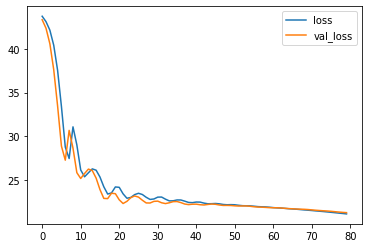

In [31]:
# from tensorflow import keras
# from tensorflow.keras import layers, callbacks
# early_stopping = callbacks.EarlyStopping(
# min_delta=0.01, # minimium amount of change to count as an improvement
# patience=5, # how many epochs to wait before stopping
# restore_best_weights=True,
# )
# model = keras.Sequential([
# layers.Dense(500, activation='relu', input_shape=[16]),
# layers.Dense(500, activation='relu'),
# layers.Dense(500, activation='relu'),
# layers.Dense(500, activation='relu'),
    
    
# layers.Dense(500, activation='relu'),
    
# # layers.Dense(200, activation='sigmoid'),
# layers.Dense(1),
# ])
# model.compile(
# optimizer='adam',
# loss='mae',
# )

# history = model.fit(
# X_train, y_train,
# validation_data=(X_val, y_val),
# batch_size=9000,
# epochs=80,
# )
# history_df = pd.DataFrame(history.history)
# history_df.loc[:, ['loss', 'val_loss']].plot();
